# Build a Multi-Omics Container for GCN Training
The goal of this little notebook is to create one HDF5 container that contains a feature matrix consisting of our multi-omics data:
* Mutation Frequencies
* Gene Expression
* Methylation
We then can train our network using the iref PPI and these different data sources.

In [1]:
import h5py, sys, os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn

sys.path.append(os.path.abspath('../../GCN'))
import gcnPreprocessing
plt.rc('font', family='Times New Roman')
%matplotlib inline

## Load the Data from three containers

In [2]:
# mutation frequencies
with h5py.File('../../data/pancancer/mutfreq_iref_unbalanced_syn.h5', 'r') as f:
    network = f['network'][:]
    mutfreq_features = f['features_mean'][:]
    #features_mean = f['features_mean'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

# methylation levels
with h5py.File('../../data/pancancer/iref_methylation_450k1000bpprom_all.h5', 'r') as f:
    meth_features = f['features'][:]
    node_names_meth = f['gene_names'][:]

# gene expression
with h5py.File('../../data/pancancer/iref_tcga_expression_filter100.h5', 'r') as f:
    ge_features = f['features'][:]
    node_names_ge = f['gene_names'][:]

In [3]:
# verify that the genes are the same and that they are in the same order
print ((node_names_ge == node_names_meth).all())
print ((node_names == node_names_meth).all())
print ((node_names == node_names_ge).all())

True
True
True


## Join Multi-Omics to form one feature matrix

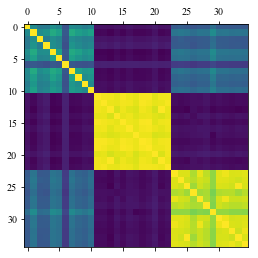

In [20]:
multi_omics_features = np.concatenate((mutfreq_features, meth_features, ge_features), axis=1)
multi_omics_features = np.delete(multi_omics_features, list(range(23,35)),axis=1)
multi_omics_features = preprocessing.quantile_transform(multi_omics_features, axis=0)
plt.matshow(np.corrcoef(multi_omics_features, rowvar=False))

array([0.34986378, 0.25581668, 0.14108959, 0.02704332, 0.02653431,
       0.02590911, 0.0245204 , 0.02400391, 0.02299874, 0.02013862,
       0.01845737, 0.01790744])

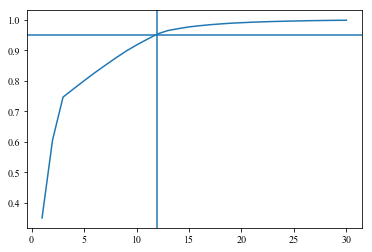

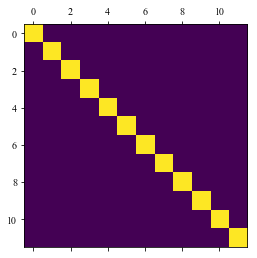

In [21]:
from sklearn.decomposition import PCA

n_components = 30
pca = PCA(n_components=n_components)
pca.fit(multi_omics_features)
plt.plot(list(range(1,n_components+1)), np.cumsum(pca.explained_variance_ratio_))
plt.axhline(0.95)
plt.axvline(12)

# take 12 components
pca = PCA(n_components=12)
pca.fit(multi_omics_features)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
features_transformed = pca.transform(multi_omics_features)
plt.matshow(np.corrcoef(features_transformed, rowvar=False))
variance_explained = pca.explained_variance_ratio_
variance_explained

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f51d187a7b8>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f51d187ad68>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f51d18769b0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f51d1876e80>}

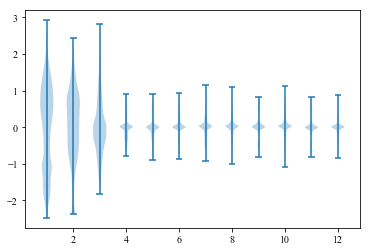

In [22]:
plt.violinplot(features_transformed)

In [23]:
cancer_names = ['blca', 'brca', 'coadread', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'ucec']
feat_names_mut = ['mutfreq_'+i for i in cancer_names]
cnames_full = ['blca', 'brca', 'coad', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'read', 'ucec']
feat_names_ge = ['ge_'+i for i in cnames_full]
feat_names_meth = ['meth_{}_prom'.format(i) for i in cnames_full]
feat_names_all = feat_names_mut + feat_names_meth + feat_names_ge

## Get Labels

In [24]:
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes.set_index('ID', inplace=True)

known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

In [25]:
# get rid of the vogelstein cancer genes
not_positives = nodes[~nodes.Name.isin(known_cancer_genes)]
print ("{} genes are in network but not in Vogelstein list (oncogenes)".format(not_positives.shape[0]))

# get rid of the OMIM disease genes
omim_genes = pd.read_csv('../../data/pancancer/OMIM/genemap2.txt', sep='\t', comment='#', header=None)
omim_genes.columns = ['Chromosome', 'Genomic Position Start', 'Genomic Position End', 'Cyto Location',
                      'Computed Cyto Location', 'Mim Number', 'Gene Symbol', 'Gene Name',
                      'Approved Symbol', 'Entrez Gene ID', 'Ensembl Gene ID', 'Comments',
                      'Phenotypes', 'Mouse Gene Symbol/ID']
omim_gene_names = []
for idx, row in omim_genes.iterrows():
    gene_names = row['Gene Symbol'].strip().split(',')
    omim_gene_names += gene_names
omim_gene_names = list(set(omim_gene_names))
not_omim_not_pos = not_positives[~not_positives.Name.isin(omim_gene_names)]
print ("{} genes are in network but not in oncogenes and not in OMIM".format(not_omim_not_pos.shape[0]))

# get rid of genes that are not in COSMIC
cosmic_gene_scores = pd.read_csv('../../data/pancancer/cosmic/cancer_gene_census.csv', header=0)
not_omim_cosmic_pos = not_omim_not_pos[~not_omim_not_pos.Name.isin(cosmic_gene_scores['Gene Symbol'])]
print ("{} genes in network but not in oncogenes, OMIM and COSMIC cancer gene census.".format(not_omim_cosmic_pos.shape[0]))

# get rid of genes that are not candidate cancer genes
negatives = not_omim_cosmic_pos[~not_omim_cosmic_pos.Name.isin(candidate_cancer_genes)]
print ("{} negatives collected".format(negatives.shape[0]))

11489 genes are in network but not in Vogelstein list (oncogenes)
2262 genes are in network but not in oncogenes and not in OMIM
2258 genes in network but not in oncogenes, OMIM and COSMIC cancer gene census.
2140 negatives collected


## Do Training and Test Split

In [26]:
y = nodes.Name.isin(known_cancer_genes_innet).values.reshape(-1, 1)
mask = nodes.Name.isin(negatives.Name) | nodes.Name.isin(known_cancer_genes_innet)

In [27]:
y_train, train_mask, y_test, test_mask = gcnPreprocessing.train_test_split(y, mask, 0.25)
y_train, train_mask, y_val, val_mask = gcnPreprocessing.train_test_split(y_train, train_mask, 0.1)
y_train.shape, train_mask.shape, y_test.shape, test_mask.shape, y_val.shape, val_mask.shape

((12129, 1), (12129,), (12129, 1), (12129,), (12129, 1), (12129,))

## Write back everything to container

In [28]:
def write_hdf5_container(fname, adj, F_trans, F_orig, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, feature_names, pca_loadings, variance_explained):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=adj, shape=adj.shape)
    f.create_dataset('features', data=F_trans, shape=F_trans.shape)
    f.create_dataset('features_orig', data=F_orig, shape=F_orig.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.create_dataset('pca_loadings', data=pca_loadings, shape=pca_loadings.shape)
    f.create_dataset('variance_explained', data=variance_explained, shape=variance_explained.shape)
    f.close()
    print ("Container written to {}".format(fname))

In [29]:
fname = '../../data/pancancer/PCA.h5'
write_hdf5_container(fname, network, features_transformed, multi_omics_features, node_names, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_all, loadings, variance_explained)

Container written to ../../data/pancancer/PCA.h5


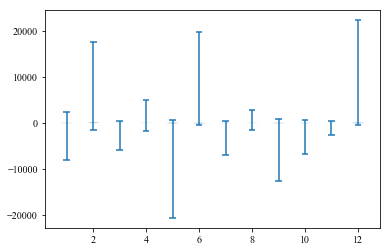

In [30]:
import utils
from scipy.sparse import lil_matrix

hm = utils.preprocess_features(lil_matrix(features_transformed), sparse=False)
_ = plt.violinplot(np.asarray(hm))
plt.show()